# Universal Protection of Arbitrary $N$-Qubit Entangled States Against Amplitude Damping Noise

In this tutorial, we provide a detailed Qiskit simulation for the escorting qubit method proposed in our paper, "Universal Protection of Arbitrary $N$-Qubit Entangled States Against Amplitude Damping Noise". We consider both two-qubit and three-qubit initial states. Additionally, the repository includes MATLAB simulation code that will assist you in calculating the state of the system at each step of the protection process.

## 1. Two-qubit initial state: Bell state

First, we begin by simulating a two-qubit state using Qiskit. The initial state is defined as
    $$|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\zeta|11\rangle $$

To ensure consistency with the results presented in the paper, we will examine the maximally entangled Bell state $|\psi\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$.

However, you can modify the values of the initial state parameters to test the universality of our proposed method for arbitrary initial states.

C:\Users\Sajede Harraz\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


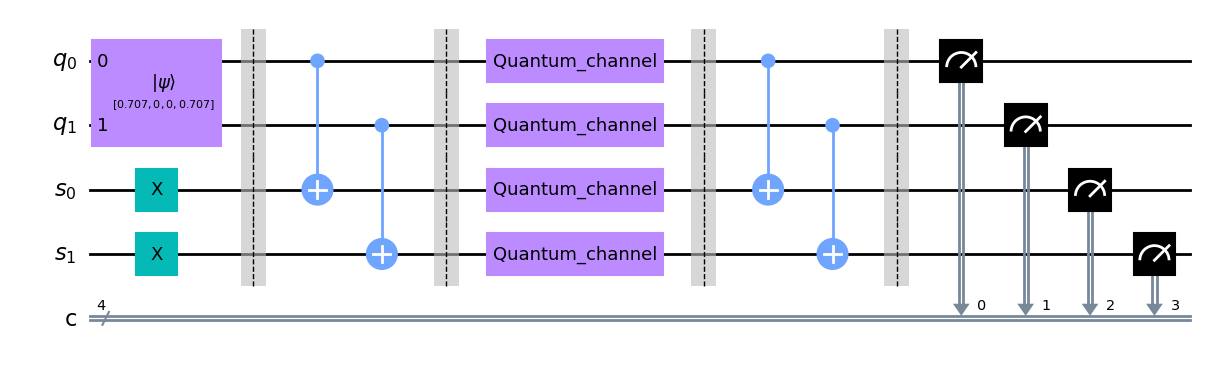

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile, assemble
from qiskit.quantum_info import partial_trace
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, pauli_error, depolarizing_error, NoiseModel, ReadoutError
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

q = QuantumRegister(2, 'q')
anc = QuantumRegister(2, 's')
c = ClassicalRegister(4, 'c')
qc = QuantumCircuit(q, anc, c)

#Preparing two escorting qubits in state |1>
qc.x(anc[0]) 
qc.x(anc[1]) 


#Preparing the initial state (here we consider maximally Bell state, change the values for your desire initial two-qubit state.)
alpha = np.sqrt(0.5)  
beta = np.sqrt(0)  
gamma=np.sqrt(0)
zeta=np.sqrt(0.5)
qc.initialize([alpha, beta, gamma, zeta], [q[0], q[1]])
qc.barrier()

#Pre-noise CNOT operations:
qc.cx(0, 2)
qc.cx(1, 3)
qc.barrier()

#All qubits pass through amplitude damping channels
r=0.4
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [0])
qc.append(error, [1])
qc.append(error, [2])
qc.append(error, [3])
qc.barrier()

#Post-noise CNOT operations:
qc.cx(0, 2)
qc.cx(1, 3)
qc.barrier()

########################## Error in CNOT gate and measurement
#### CNOT error
error_rate_cnot =0   #CNOT gate error rate
cnot_error = depolarizing_error(error_rate_cnot, 2)
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', [2,0])
noise_model.add_quantum_error(cnot_error, 'cx', [3,1])

####  read out error
eta=0
error_meas = ReadoutError([[1- eta, eta], [eta, 1- eta]])
noise_model.add_readout_error(error_meas, [2])
noise_model.add_readout_error(error_meas, [3])

qc.measure([0,1,2,3],[0,1,2,3])
# Plot the circuit
qc.draw('mpl')

In [3]:
qc=qc.reverse_bits ()
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method,noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'0011': 17874, '0001': 11901, '1010': 12044, '0000': 16123, '0101': 12046, '1111': 17814, '0010': 12198}


Qiskit Probability= 0.35688
Mathematical probability= 0.36


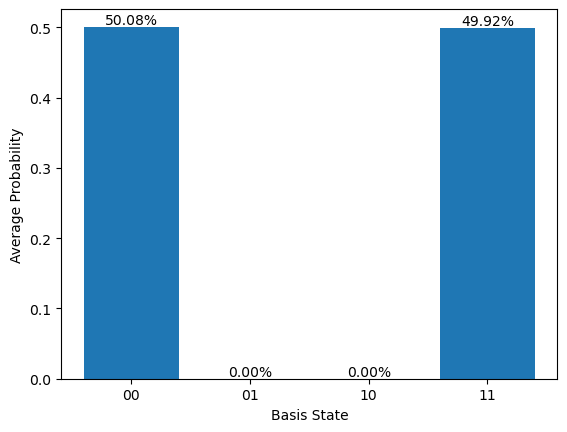

In [4]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[-1]=='1' and jj[-2]=='1' ): #Escort qubit measurement for both escort qubits 1
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last two character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[:2]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
            
# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state

### Success probability:
print('Qiskit Probability=',success/total)
print('Mathematical probability=',(1-r)**2)

# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()

As seen from the Qiskit simulation results, the initial maximally entangled state is successfully recovered when the measurement results of the escort qubits are '1'.

## 2. Three-qubit initial state: Werner state

Now let us consider three-qubit as the initial state to be protected in presence of amplitude damping noise. The general representation of three-qubit state is
$$|\psi\rangle=a|000\rangle+b|001\rangle+c|010\rangle+d|011\rangle+e|100\rangle+f|101\rangle+g|110\rangle+h|111\rangle$$

Here we will consider the Werner state $|w\rangle=\frac{1}{\sqrt{3}}(|001\rangle+|010\rangle+|100\rangle)$ as the initial state. However, you can modify the values of the initial state parameters to test the universality of our proposed method for arbitrary initial states.

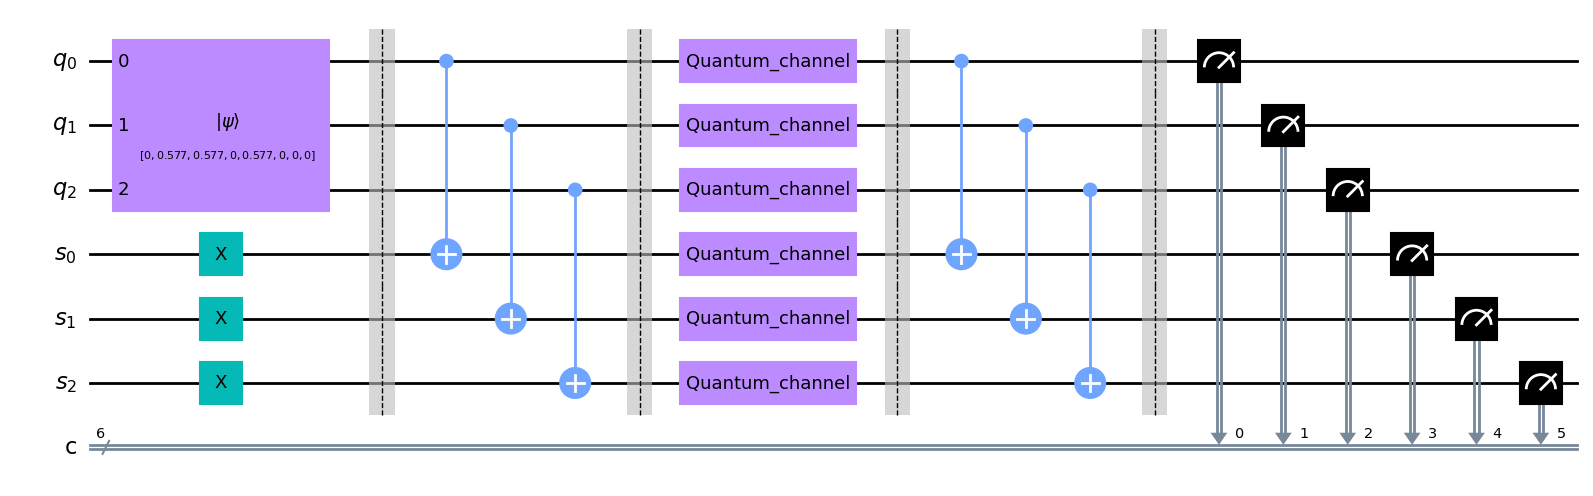

In [5]:
q = QuantumRegister(3, 'q')
anc = QuantumRegister(3, 's')
c = ClassicalRegister(6, 'c')
qc = QuantumCircuit(q, anc, c)


#Preparing three escorting qubits in state |1>
qc.x(anc[0]) 
qc.x(anc[1]) 
qc.x(anc[2]) 

#Preparing the initial state (here we consider Werner state, change the values for your desire initial three-qubit state.)
a=0
b=1/np.sqrt(3)
c=1/np.sqrt(3)
d=0
e=1/np.sqrt(3)
f=0
g=0
h=0

qc.initialize([a,b,c,d,e,f,g,h], [q[0], q[1], q[2]])
qc.barrier()

qc.cx(0, 3)
qc.cx(1, 4)
qc.cx(2, 5)
qc.barrier()

r=0.4
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [0])
qc.append(error, [1])
qc.append(error, [2])
qc.append(error, [3])
qc.append(error, [4])
qc.append(error, [5])

qc.barrier()
qc.cx(0, 3)
qc.cx(1, 4)
qc.cx(2, 5)
qc.barrier()

qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5])

# Plot the circuit
qc.draw('mpl')

In [6]:
qc=qc.reverse_bits ()
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'100100': 3277, '001101': 4768, '010110': 4776, '100111': 7192, '010111': 7376, '000000': 6337, '000010': 6457, '000001': 6340, '000110': 4864, '001011': 4795, '000101': 4667, '000100': 6366, '100110': 4689, '001111': 7164, '010011': 4771, '010010': 3143, '100101': 4933, '000011': 4845, '001001': 3240}


Qiskit Probability= 0.21732
Mathematical probability= 0.21599999999999997


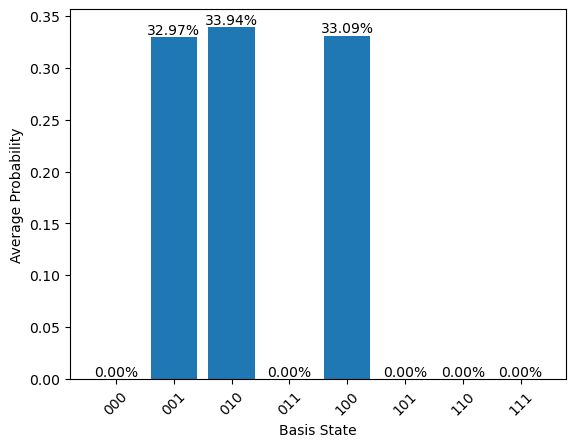

In [7]:
success, fail = 0, 0
Bell_states = {}
Bell_new = {}

for jj in counts:
    if (jj[-1]=='1' and jj[-2]=='1' and jj[-3]=='1'): #ancilla qubit measurement 1
        success += counts[jj]
        Bell_state = jj
        if Bell_state in Bell_states:
            Bell_states[Bell_state] += counts[jj]
        else:
            Bell_states[Bell_state] = counts[jj]
    else:
        fail += counts[jj]

total = success + fail

# Extract the target qubits state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[:3]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('Qiskit Probability=',success/total)
print('Mathematical probability=',(1-r)**3)

# Convert counts to a sorted list of probabilities
basis_states = ['000', '001', '010', '011', '100', '101', '110', '111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states]

# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
#plt.title(f'Average Probability of Basis States (r={r})')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
# Add percentage labels on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()


As seen from the Qiskit simulation results, the initial Werner state is successfully recovered when the measurement results of all the escort qubits are '1'.